In [1]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.environ.get('PATH_CUSTOM_MODULES'))

import modeling

### Prepare all basic variable

In [2]:
path_result = os.environ.get('PATH_TEST_RESULT')
path_storage = os.environ.get('PATH_EVALUATION_RESULT')

### Getting the result data

In [3]:
result = modeling.merge_result_data(path_src=path_result)

In [4]:
# store the merged result
result.to_csv(os.path.join(path_storage,
                            'merge_result.csv'),
                index=False)

### Get the final result from cross validation

In [5]:
result.drop(columns=['fold'], inplace=True)
result_final = result.groupby(by=['scenario', 'model', 'dataset']).agg('mean')

In [6]:
result_final.head(1)

,,,loss,auc,true_positive,true_negative,false_positive,false_negative
scenario,model,dataset,,,,,,
scenario_1,efficientnet_v2l,g1020,0.60588,0.496924,144.8,0.0,59.2,0.0


### Get the matrixes

#### Sensitivity

In [7]:
result_final['sensitivity'] = (result_final.true_positive
                            / (result_final.true_positive + result_final.false_negative))

#### Precision

In [8]:
result_final['precision'] = (result_final.true_positive
                            / (result_final.true_positive + result_final.false_positive))

#### accuracy

In [9]:
result_final['accuracy'] = ((result_final.true_positive + result_final.true_negative)
                            / (result_final.true_positive + result_final.true_negative
                                + result_final.false_positive + result_final.false_negative))

#### F1-score

In [10]:
result_final['f1_score'] = 2*((result_final['precision'] * result_final['sensitivity'])
                                / (result_final['precision'] + result_final['sensitivity']))

### Save the result

In [11]:
result_final.reset_index(level=[0,1,2], inplace=True)

In [12]:
result_final = result_final[['scenario', 'model', 'dataset',
                            'auc', 'f1_score', 'accuracy', 'precision',
                            'sensitivity', 'loss',
                            'true_positive', 'true_negative',
                            'false_positive', 'false_negative']]

In [13]:
result_final.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'],
                        ascending=False, inplace=True, ignore_index=True)

result_final.to_csv(os.path.join(path_storage,
                                'merge_result_final.csv'),
                    index=False)

### Setup

In [14]:
import pandas as pd
pd.options.mode.copy_on_write = True

### Analyze the result

#### General Result

In [15]:
general_result = result_final[['model',
                            'auc', 'f1_score', 'accuracy', 'precision']].groupby(by=['model']).agg('mean')

general_result.reset_index(level=0, inplace=True)
general_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

general_result.to_csv(os.path.join(path_storage,
                                'general_result.csv'),
                    index=False)

general_result

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.755690,0.850601,0.778907,0.820392
1,efficientnet_v2s,0.596342,0.842422,0.734141,0.735819
2,efficientnet_v2l,0.592552,0.842809,0.735932,0.737082
3,efficientnet_v2m,0.588622,0.843328,0.734385,0.734385
4,mobilenet_v3large,0.583964,0.843180,0.734177,0.734433
5,mobilenet_v3small,0.567779,0.837852,0.729918,0.734527


#### By scenario

##### Scenario 1

In [16]:
# the general result
s1_result = result_final.groupby(by='scenario').get_group('scenario_1')

s1_result.drop(columns=['scenario', 'loss', 'sensitivity'], inplace=True)
s1_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s1_result.to_csv(os.path.join(path_storage,
                            's1_general_result.csv'),
                index=False)

s1_result.head(5)

,model,dataset,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,mobilenet_v2,refuge,0.918615,0.963669,0.933333,0.945633,212.2,11.8,12.2,3.8
1,mobilenet_v2,rimone,0.891411,0.852201,0.806186,0.839009,54.2,24.0,10.4,8.4
2,mobilenet_v2,papila,0.727745,0.824176,0.737705,0.759494,60.0,12.0,19.0,6.6
3,efficientnet_v2s,refuge,0.704610,0.947784,0.900833,0.900751,216.0,0.2,23.8,0.0
4,efficientnet_v2m,rimone,0.680477,0.784461,0.645361,0.645361,62.6,0.0,34.4,0.0


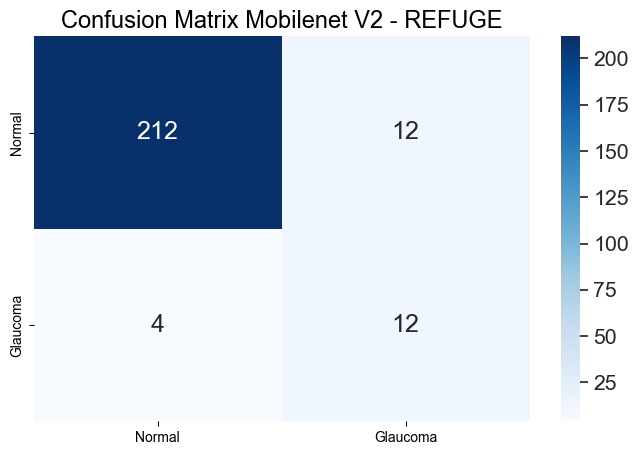

In [17]:
# visualize the confusion matrix of s1 general best
modeling.confusion_matrix_plot_highest(result=s1_result,
                                        place=0,
                                        model_name='Mobilenet V2 - REFUGE',
                                        path_dest=path_storage,
                                        file_name='s1_general_best')

In [18]:
# summarize only the model
s1_result_sumarize = s1_result[['model',
                                'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

s1_result_sumarize.reset_index(level=0, inplace=True)
s1_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s1_result_sumarize.to_csv(os.path.join(path_storage,
                                    's1_summarize_result.csv'),
                        index=False)

s1_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.755323,0.858917,0.786953,0.813751
1,efficientnet_v2l,0.578307,0.843328,0.734385,0.734385
2,efficientnet_v2m,0.575380,0.843328,0.734385,0.734385
3,mobilenet_v3large,0.572600,0.842883,0.733760,0.734529
4,efficientnet_v2s,0.564985,0.842673,0.734594,0.735957
5,mobilenet_v3small,0.528258,0.843328,0.734385,0.734385


##### Scenario 2

In [19]:
# the general result
s2_result = result_final.groupby(by='scenario').get_group('scenario_2')

s2_result.drop(columns=['scenario', 'loss', 'sensitivity'], inplace=True)
s2_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s2_result.to_csv(os.path.join(path_storage,
                            's2_general_result.csv'),
                index=False)

s2_result.head(5)

,model,dataset,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,mobilenet_v2,refuge,0.917940,0.947418,0.906667,0.960952,201.8,15.8,8.2,14.2
1,mobilenet_v2,rimone,0.908892,0.881203,0.837113,0.832386,58.6,22.6,11.8,4.0
2,efficientnet_v2s,refuge,0.748823,0.947276,0.900000,0.901338,215.6,0.4,23.6,0.4
3,mobilenet_v2,papila,0.739058,0.781437,0.700820,0.779104,52.2,16.2,14.8,14.4
4,efficientnet_v2m,rimone,0.682539,0.784461,0.645361,0.645361,62.6,0.0,34.4,0.0


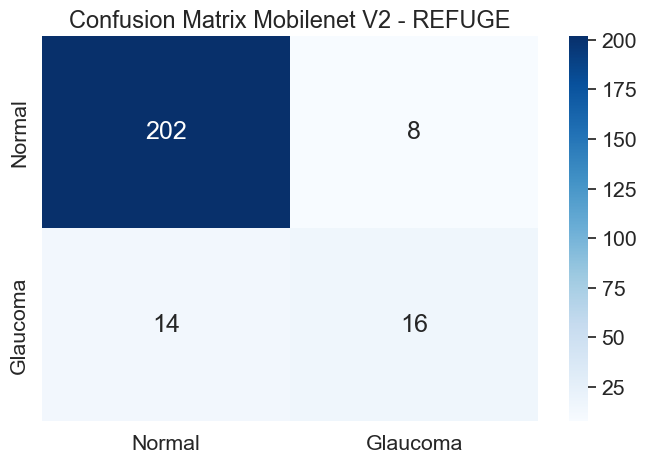

In [20]:
# visualize the confusion matrix of s1 general best
modeling.confusion_matrix_plot_highest(result=s2_result,
                                        place=0,
                                        model_name='Mobilenet V2 - REFUGE',
                                        path_dest=path_storage,
                                        file_name='s2_general_best')

In [21]:
# summarize only the model
s2_result_sumarize = s2_result[['model',
                                'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

s2_result_sumarize.reset_index(level=0, inplace=True)
s2_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s2_result_sumarize.to_csv(os.path.join(path_storage,
                                    's2_summarize_result.csv'),
                        index=False)

s2_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.763789,0.840178,0.767522,0.821019
1,efficientnet_v2l,0.591429,0.843328,0.734385,0.734385
2,mobilenet_v3large,0.583970,0.843328,0.734385,0.734385
3,efficientnet_v2m,0.582980,0.843328,0.734385,0.734385
4,efficientnet_v2s,0.576484,0.843260,0.734631,0.735185
5,mobilenet_v3small,0.538544,0.843328,0.734385,0.734385


##### Scenario 3

In [22]:
# the general result
s3_result = result_final.groupby(by='scenario').get_group('scenario_3')

s3_result.drop(columns=['scenario', 'loss', 'sensitivity'], inplace=True)
s3_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s3_result.to_csv(os.path.join(path_storage,
                            's3_general_result.csv'),
                index=False)

s3_result.head(5)

,model,dataset,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,mobilenet_v2,rimone,0.910473,0.888535,0.855670,0.885714,55.8,27.2,7.2,6.8
1,mobilenet_v2,refuge,0.884915,0.956164,0.920000,0.943243,209.4,11.4,12.6,6.6
2,efficientnet_v2s,refuge,0.828183,0.948109,0.901667,0.902848,215.6,0.8,23.2,0.4
3,mobilenet_v2,papila,0.742150,0.797101,0.713115,0.770308,55.0,14.6,16.4,11.6
4,mobilenet_v3small,rimone,0.731954,0.718750,0.591753,0.647059,50.6,6.8,27.6,12.0


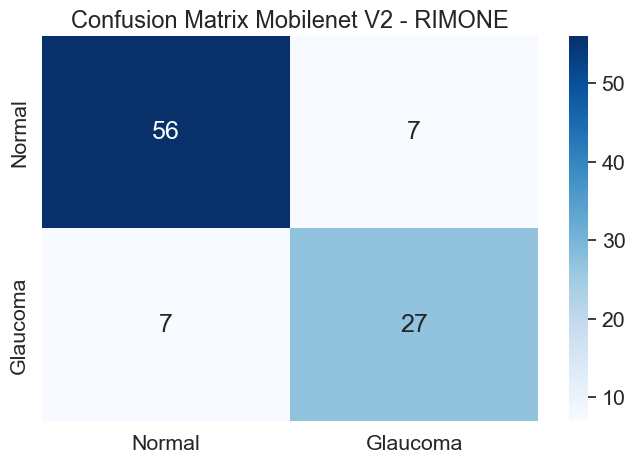

In [23]:
# visualize the confusion matrix of s1 general best
modeling.confusion_matrix_plot_highest(result=s3_result,
                                        place=0,
                                        model_name='Mobilenet V2 - RIMONE',
                                        path_dest=path_storage,
                                        file_name='s3_general_best')

In [24]:
# summarize only the model
s3_result_sumarize = s3_result[['model',
                                'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

s3_result_sumarize.reset_index(level=0, inplace=True)
s3_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

s3_result_sumarize.to_csv(os.path.join(path_storage,
                                    's3_summarize_result.csv'),
                        index=False)

s3_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.747957,0.852709,0.782245,0.826406
1,efficientnet_v2s,0.647555,0.841332,0.733199,0.736316
2,mobilenet_v3small,0.636534,0.826900,0.720983,0.734810
3,efficientnet_v2l,0.607921,0.841770,0.739025,0.742477
4,efficientnet_v2m,0.607504,0.843328,0.734385,0.734385
5,mobilenet_v3large,0.595323,0.843328,0.734385,0.734385


#### By Dataset

##### RIMONE

In [25]:
rimone_result = result_final.groupby(by='dataset').get_group('rimone')

rimone_result.drop(columns=['dataset', 'loss', 'sensitivity'], inplace=True)
rimone_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

rimone_result.to_csv(os.path.join(path_storage,
                                'rimone_general_result.csv'),
                    index=False)

rimone_result.head(5)

,scenario,model,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,scenario_3,mobilenet_v2,0.910473,0.888535,0.855670,0.885714,55.8,27.2,7.2,6.8
1,scenario_2,mobilenet_v2,0.908892,0.881203,0.837113,0.832386,58.6,22.6,11.8,4.0
2,scenario_1,mobilenet_v2,0.891411,0.852201,0.806186,0.839009,54.2,24.0,10.4,8.4
3,scenario_3,mobilenet_v3small,0.731954,0.718750,0.591753,0.647059,50.6,6.8,27.6,12.0
4,scenario_3,efficientnet_v2l,0.715976,0.778231,0.663918,0.677725,57.2,7.2,27.2,5.4


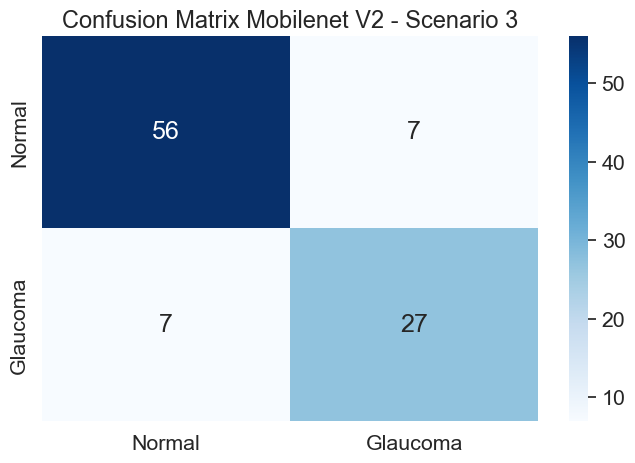

In [26]:
modeling.confusion_matrix_plot_highest(result=rimone_result,
                                        place=0,
                                        model_name='Mobilenet V2 - Scenario 3',
                                        path_dest=path_storage,
                                        file_name='rimone_general_best')

In [27]:
rimone_result_sumarize = rimone_result[['model',
                                        'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

rimone_result_sumarize.reset_index(level=0, inplace=True)
rimone_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

rimone_result_sumarize.to_csv(os.path.join(path_storage,
                                        'rimone_summarize_result.csv'),
                            index=False)

rimone_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.903592,0.873980,0.832990,0.852370
1,efficientnet_v2m,0.689582,0.784461,0.645361,0.645361
2,efficientnet_v2l,0.674544,0.782385,0.651546,0.656149
3,mobilenet_v3large,0.654589,0.784461,0.645361,0.645361
4,mobilenet_v3small,0.596583,0.762557,0.627491,0.645927
5,efficientnet_v2s,0.545131,0.784461,0.645361,0.645361


##### REFUGE

In [28]:
refuge_result = result_final.groupby(by='dataset').get_group('refuge')

refuge_result.drop(columns=['dataset', 'loss', 'sensitivity'], inplace=True)
refuge_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

refuge_result.to_csv(os.path.join(path_storage,
                                'refuge_general_result.csv'),
                    index=False)

refuge_result.head(5)

,scenario,model,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,scenario_1,mobilenet_v2,0.918615,0.963669,0.933333,0.945633,212.2,11.8,12.2,3.8
1,scenario_2,mobilenet_v2,0.917940,0.947418,0.906667,0.960952,201.8,15.8,8.2,14.2
2,scenario_3,mobilenet_v2,0.884915,0.956164,0.920000,0.943243,209.4,11.4,12.6,6.6
3,scenario_3,efficientnet_v2s,0.828183,0.948109,0.901667,0.902848,215.6,0.8,23.2,0.4
4,scenario_2,efficientnet_v2s,0.748823,0.947276,0.900000,0.901338,215.6,0.4,23.6,0.4


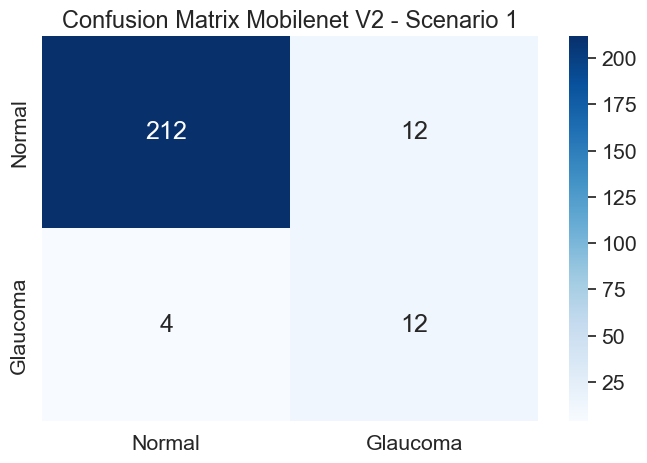

In [29]:
modeling.confusion_matrix_plot_highest(result=refuge_result,
                                        place=0,
                                        model_name='Mobilenet V2 - Scenario 1',
                                        path_dest=path_storage,
                                        file_name='refuge_general_best')

In [30]:
refuge_result_sumarize = refuge_result[['model',
                                        'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

refuge_result_sumarize.reset_index(level=0, inplace=True)
refuge_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

refuge_result_sumarize.to_csv(os.path.join(path_storage,
                                        'refuge_summarize_result.csv'),
                            index=False)

refuge_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.907157,0.955751,0.920000,0.949943
1,efficientnet_v2s,0.760539,0.947723,0.900833,0.901645
2,mobilenet_v3small,0.645653,0.947368,0.900000,0.900000
3,efficientnet_v2l,0.645338,0.947368,0.900000,0.900000
4,mobilenet_v3large,0.643859,0.946906,0.899167,0.899916
5,efficientnet_v2m,0.615811,0.947368,0.900000,0.900000


##### G1020

In [31]:
g1020_result = result_final.groupby(by='dataset').get_group('g1020')

g1020_result.drop(columns=['dataset', 'loss', 'sensitivity'], inplace=True)
g1020_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

g1020_result.to_csv(os.path.join(path_storage,
                                'g1020_general_result.csv'),
                    index=False)

g1020_result.head(5)

,scenario,model,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,scenario_3,efficientnet_v2s,0.513046,0.832757,0.715686,0.714851,144.4,1.6,57.6,0.4
1,scenario_2,efficientnet_v2m,0.511129,0.830275,0.709804,0.709804,144.8,0.0,59.2,0.0
2,scenario_2,efficientnet_v2l,0.508932,0.830275,0.709804,0.709804,144.8,0.0,59.2,0.0
3,scenario_1,mobilenet_v3small,0.505497,0.830275,0.709804,0.709804,144.8,0.0,59.2,0.0
4,scenario_1,mobilenet_v3large,0.504011,0.829885,0.709804,0.710630,144.4,0.4,58.8,0.4


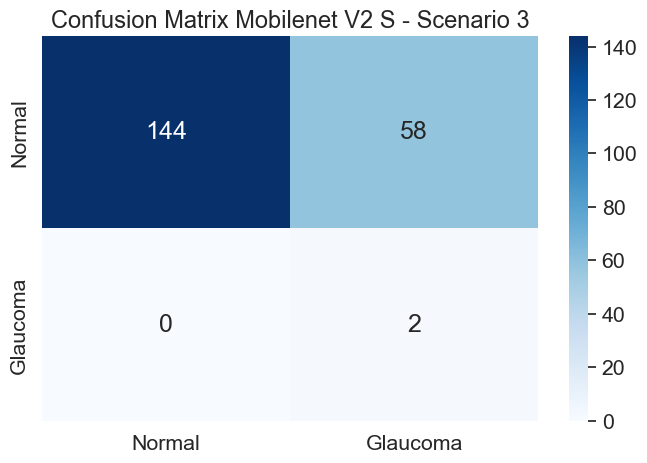

In [32]:
modeling.confusion_matrix_plot_highest(result=g1020_result,
                                        place=0,
                                        model_name='Mobilenet V2 S - Scenario 3',
                                        path_dest=path_storage,
                                        file_name='g1020_general_best')

In [33]:
g1020_result_sumarize = g1020_result[['model',
                                    'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

g1020_result_sumarize.reset_index(level=0, inplace=True)
g1020_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

g1020_result_sumarize.to_csv(os.path.join(path_storage,
                                        'g1020_summarize_result.csv'),
                            index=False)

g1020_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v3large,0.502781,0.830145,0.709804,0.710079
1,efficientnet_v2l,0.502438,0.830275,0.709804,0.709804
2,mobilenet_v3small,0.500717,0.830275,0.709804,0.709804
3,efficientnet_v2s,0.499506,0.830804,0.712092,0.712689
4,efficientnet_v2m,0.491808,0.830275,0.709804,0.709804
5,mobilenet_v2,0.475694,0.771770,0.645425,0.709621


##### PAPILA

In [34]:
papila_result = result_final.groupby(by='dataset').get_group('papila')

papila_result.drop(columns=['dataset', 'loss', 'sensitivity'], inplace=True)
papila_result.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

papila_result.to_csv(os.path.join(path_storage,
                                'papila_general_result.csv'),
                    index=False)

papila_result.head(5)

,scenario,model,auc,f1_score,accuracy,precision,true_positive,true_negative,false_positive,false_negative
0,scenario_3,mobilenet_v2,0.742150,0.797101,0.713115,0.770308,55.0,14.6,16.4,11.6
1,scenario_2,mobilenet_v2,0.739058,0.781437,0.700820,0.779104,52.2,16.2,14.8,14.4
2,scenario_1,mobilenet_v2,0.727745,0.824176,0.737705,0.759494,60.0,12.0,19.0,6.6
3,scenario_3,efficientnet_v2s,0.613598,0.800000,0.670082,0.682203,64.4,1.0,30.0,2.2
4,scenario_3,efficientnet_v2m,0.594689,0.811206,0.682377,0.682377,66.6,0.0,31.0,0.0


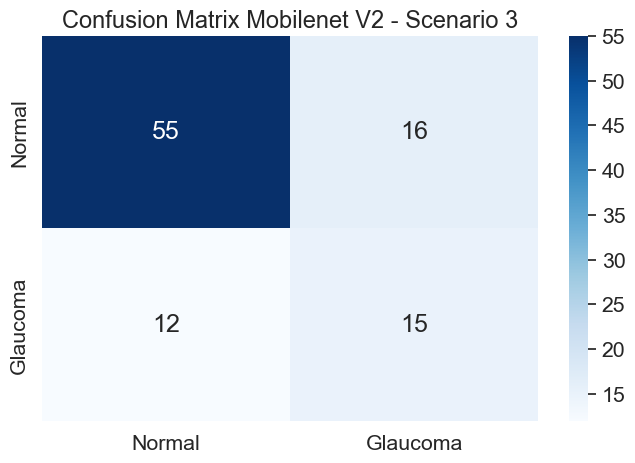

In [35]:
modeling.confusion_matrix_plot_highest(result=papila_result,
                                        place=0,
                                        model_name='Mobilenet V2 - Scenario 3',
                                        path_dest=path_storage,
                                        file_name='papila_general_best')

In [36]:
papila_result_sumarize = papila_result[['model',
                                        'auc', 'f1_score', 'accuracy', 'precision']].groupby(by='model').agg('mean')

papila_result_sumarize.reset_index(level=0, inplace=True)
papila_result_sumarize.sort_values(by=['auc', 'f1_score', 'accuracy', 'precision'], ascending=False, inplace=True, ignore_index=True)

papila_result_sumarize.to_csv(os.path.join(path_storage,
                                        'papila_summarize_result.csv'),
                            index=False)

papila_result_sumarize

,model,auc,f1_score,accuracy,precision
0,mobilenet_v2,0.736318,0.800905,0.717213,0.769635
1,efficientnet_v2s,0.580190,0.806698,0.678279,0.683583
2,efficientnet_v2m,0.557284,0.811206,0.682377,0.682377
3,efficientnet_v2l,0.547890,0.811206,0.682377,0.682377
4,mobilenet_v3large,0.534628,0.811206,0.682377,0.682377
5,mobilenet_v3small,0.528162,0.811206,0.682377,0.682377
